# Striplog from image

We're going to try to make a striplog from an image of a striplog. The impage is Figure 1 from Audrey Estublier*,  Alexandre Fornel,  Étienne Brosse,  Pascal Houel,  Jean-Claude Lecomte,Jocelyne Delmas  and  Olivier Vincké (2017). Simulation of a Potential CO2Storage in the West ParisBasin: Site Characterization and Assessment of theLong-Term Hydrodynamical and Geochemical ImpactsInduced by the CO2Injection. Oil & Gas Science and Technology–Rev. IFP Energies nouvelles (2017) 72, 22. DOI:10.2516/ogst/2017021, licensed CC-BY 4.0.

Fingers crossed!

In [1]:
import matplotlib.pyplot as plt
import numpy as np

This notebook works best with Striplog v0.8.8.

In [2]:
import striplog

striplog.__version__

'0.8.8'

I checked the PDF and unfortunately the artwork is not stored as vector art &mdash; it's a raster. So we'll just have to deal with the various bits of decoration and the low resolution.

Here's the whole page as a PNG.

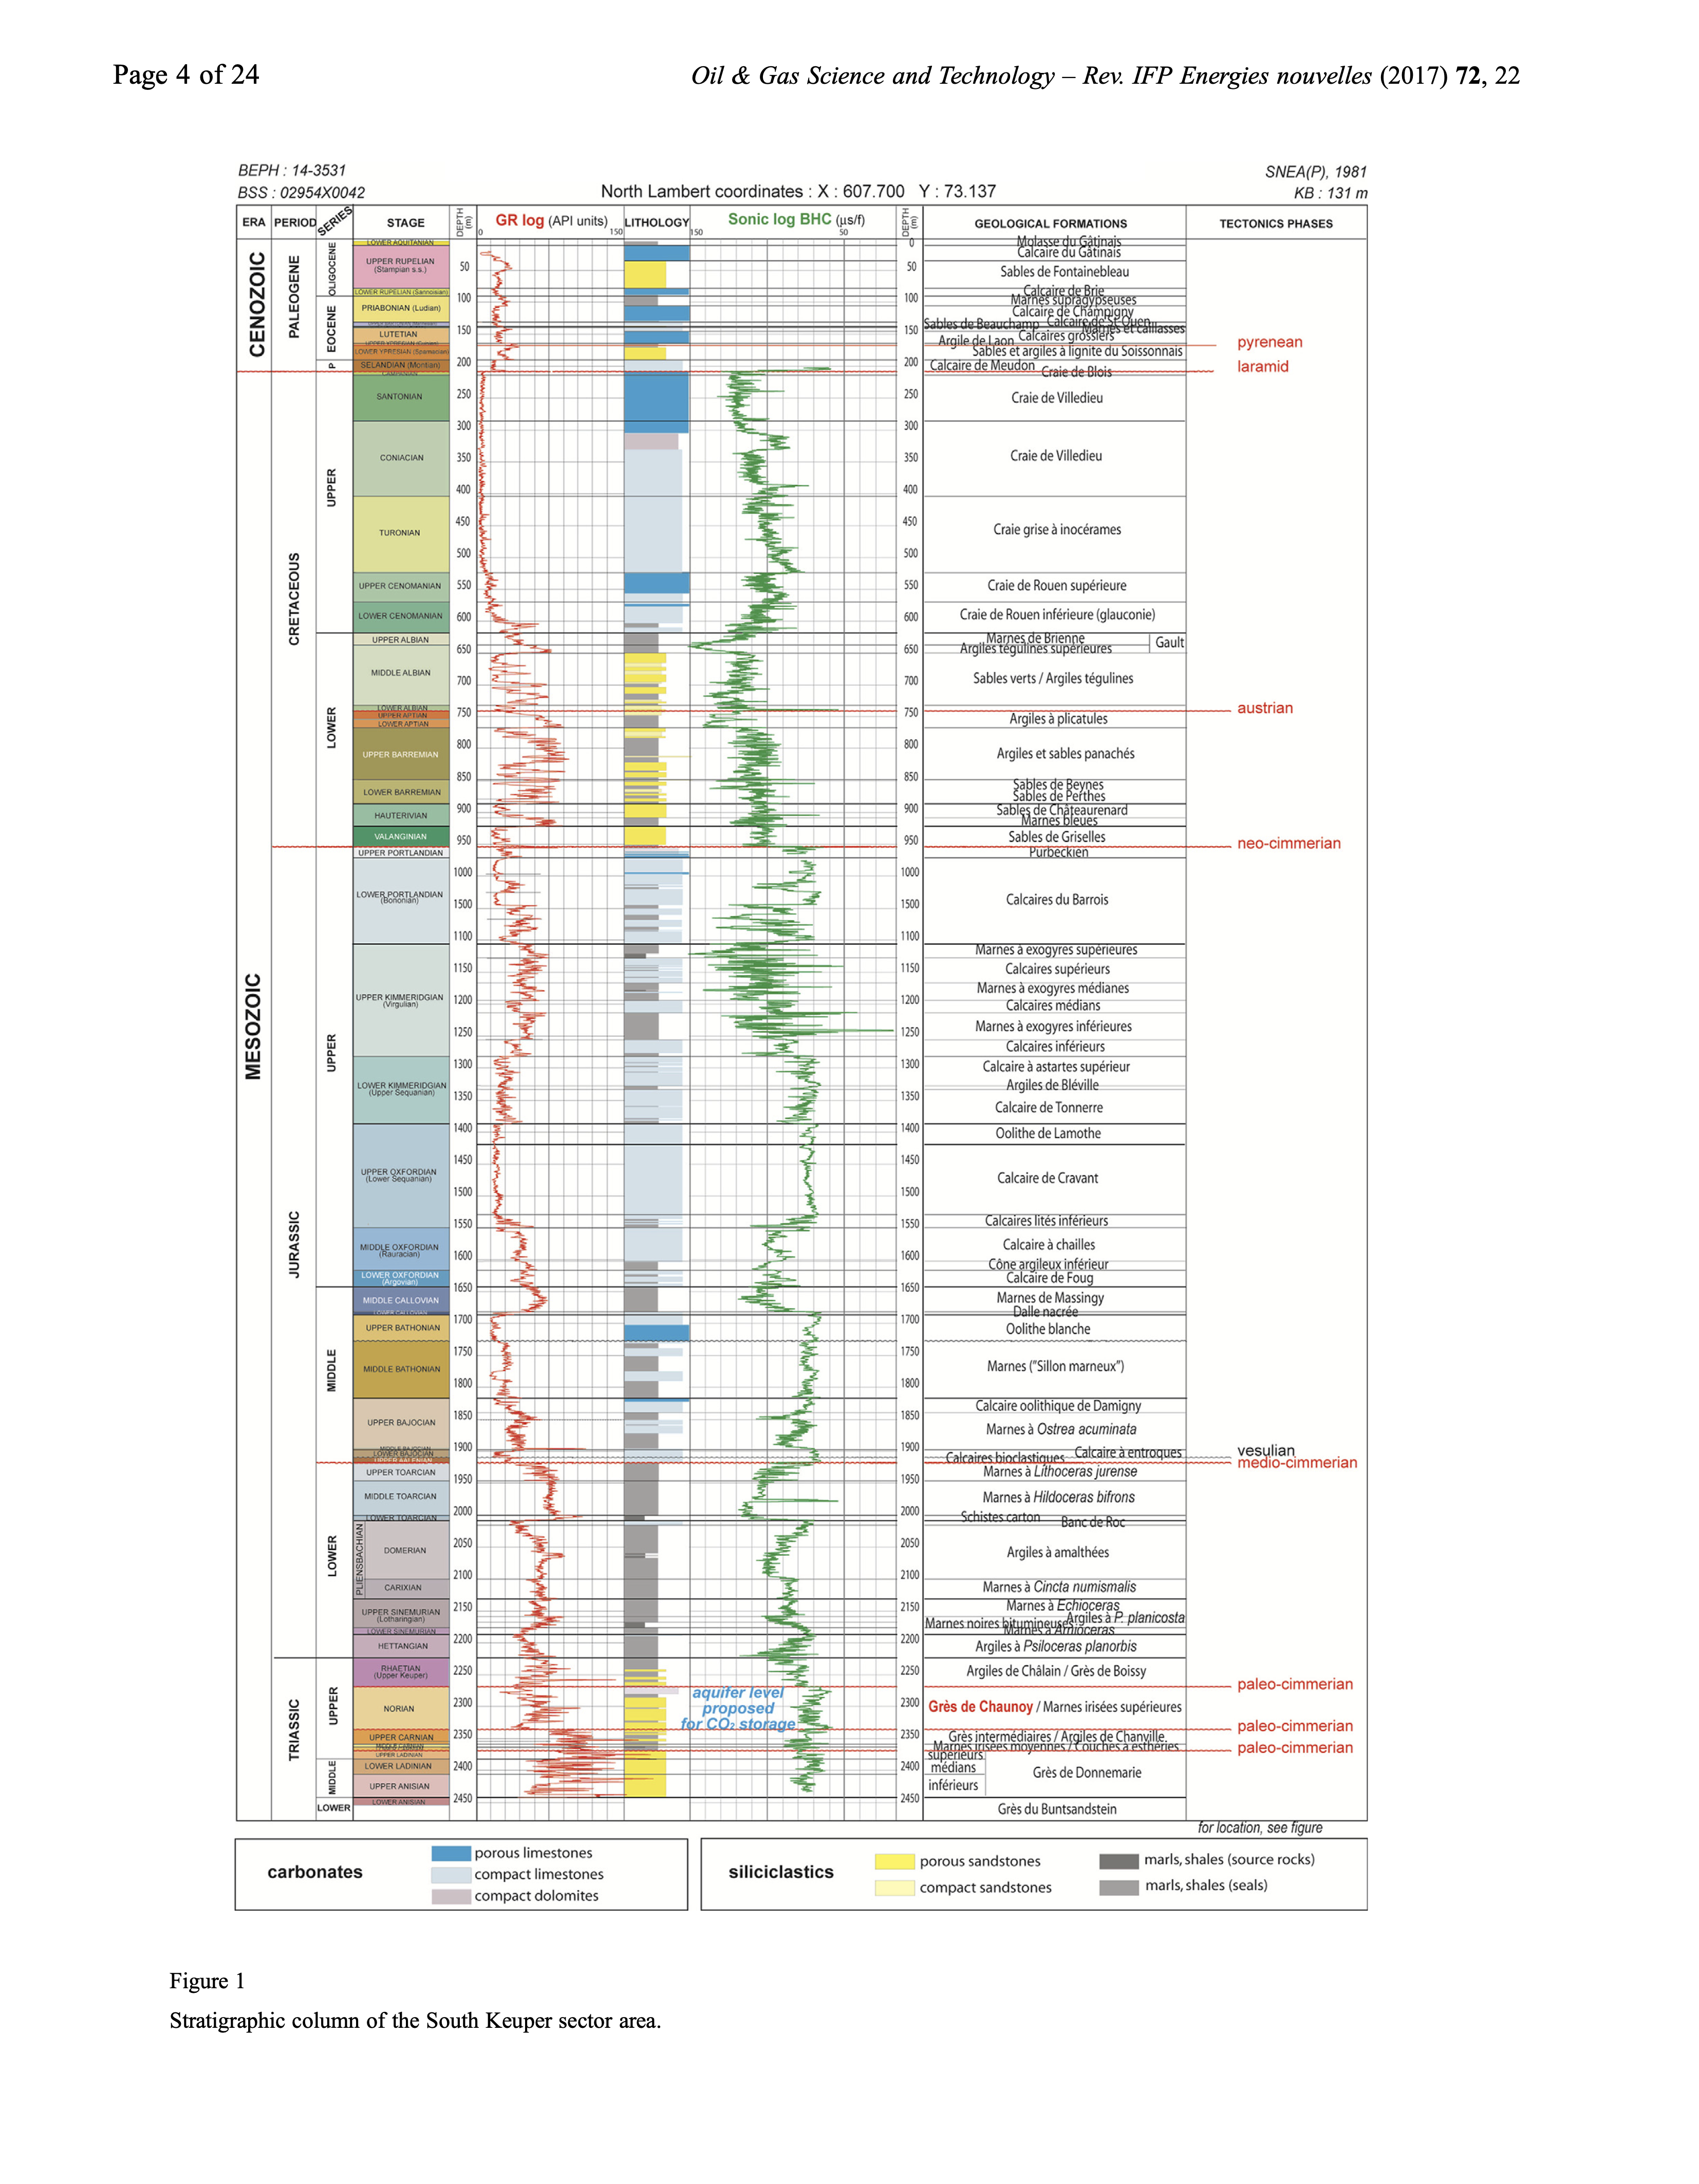

In [3]:
from IPython.display import Image

Image("./data/ogst160144.png", width=400)

We need to know the start and end depth, so I cropped out just the striplog itself. It goes from 0 m to 2450 m.

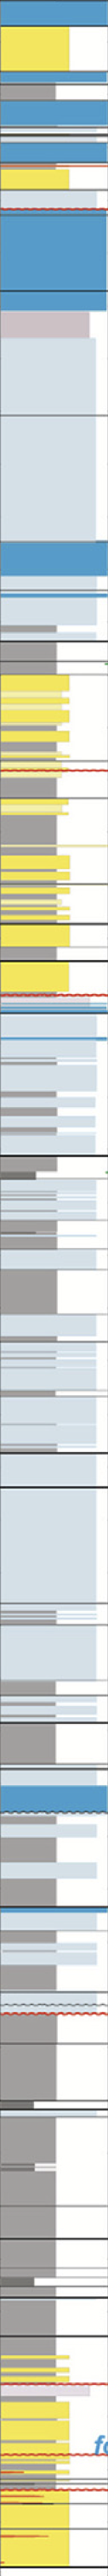

In [4]:
Image("./data/ogst160144_striplog-only.png")

Some of the decoration might cause problems, let's see.

## Make a legend

`Striplog`s are made of `Interval`s.

`Interval`s (usually) contain `Component`s. 

The `Legend` is the lookup table for the `Component`s we're going to place in the `Interval`s.

The colours just have to be close to the colours in the image.

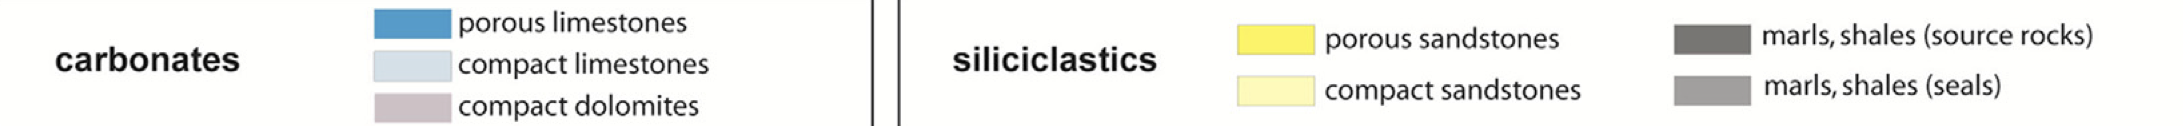

In [5]:
Image("./data/ogst160144_legend.png")

We need 'Components'. They are defined by property dictionaries, which can contain whatever we want.

In [24]:
from striplog import Legend

legend_text = """colour,width,comp lithology,comp properties,comp role
#509ccc,10,limestone,porous,
#d2e1e8,9,limestone,compact,
#bdc6c8,8,dolomite,compact,
#f8e753,6,sandstone,porous,
#ede8a7,5,sandstone,compact,
#787775,3,marl/shale,,source rock
#a4a09f,4,marl/shale,,seal
"""

legend = Legend.from_csv(text=legend_text)
legend

Legend(Decor({'_colour': '#509ccc', 'width': 10.0, 'component': Component({'lithology': 'limestone', 'properties': 'porous'}), 'hatch': None})
Decor({'_colour': '#d2e1e8', 'width': 9.0, 'component': Component({'lithology': 'limestone', 'properties': 'compact'}), 'hatch': None})
Decor({'_colour': '#bdc6c8', 'width': 8.0, 'component': Component({'lithology': 'dolomite', 'properties': 'compact'}), 'hatch': None})
Decor({'_colour': '#f8e753', 'width': 6.0, 'component': Component({'lithology': 'sandstone', 'properties': 'porous'}), 'hatch': None})
Decor({'_colour': '#ede8a7', 'width': 5.0, 'component': Component({'lithology': 'sandstone', 'properties': 'compact'}), 'hatch': None})
Decor({'_colour': '#787775', 'width': 3.0, 'component': Component({'lithology': 'marl/shale', 'role': 'source rock'}), 'hatch': None})
Decor({'_colour': '#a4a09f', 'width': 4.0, 'component': Component({'lithology': 'marl/shale', 'role': 'seal'}), 'hatch': None}))

## Making a `striplog`

In [27]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

img = plt.imread("./data/ogst160144_striplog-only.png")[:, 10, :3]
kmeans = KMeans(n_clusters=12).fit(img)
quanta = kmeans.cluster_centers_[kmeans.labels_]
plt.imsave("./data/ogst160144_striplog-only_quantized.png", quanta.reshape(-1, 1, 3))

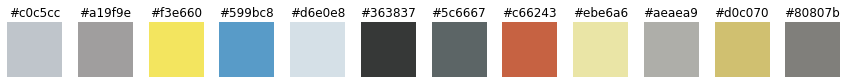

In [28]:
fig, axs = plt.subplots(figsize=(15, 1), ncols=12)
for c, ax in zip(kmeans.cluster_centers_, axs):
    ax.imshow(c.reshape(1,1,3))
    ax.set_title(striplog.utils.rgb_to_hex(c))
    ax.axis('off')

In [29]:
from striplog import Striplog

strip = Striplog.from_img("./data/ogst160144_striplog-only_quantized.png",
                          start=0, stop=2450,
                          col_offset=0,     # How far across the image to extract pixels.
                          legend=legend,
                          tolerance=20,     # How forgiving to be on the colours.
                          row_offset=2,      # How far below a boundary to look at the colour.
                          background='#ffffff',  # Ignore this colour
                         )

# Expect warnings for colours which don't match the legend.

/Users/matt/opt/miniconda3/envs/py39/lib/python3.9/site-packages/striplog/striplog.py:892: UserWarning: from_img() is deprecated; please use from_image()
  warnings.warn(w)
/Users/matt/opt/miniconda3/envs/py39/lib/python3.9/site-packages/striplog/legend.py:897: UserWarning: No match found for #c66242 with tolerance of 20. Best match is Marl/shale, source rock, #787775, d=95.53009996854395
  warnings.warn(w)
/Users/matt/opt/miniconda3/envs/py39/lib/python3.9/site-packages/striplog/legend.py:897: UserWarning: No match found for #d0c070 with tolerance of 20. Best match is Sandstone, porous, #f8e753, d=62.94441992742486
  warnings.warn(w)
/Users/matt/opt/miniconda3/envs/py39/lib/python3.9/site-packages/striplog/legend.py:897: UserWarning: No match found for #363837 with tolerance of 20. Best match is _, #000000, d=95.2732911156112
  warnings.warn(w)
/Users/matt/opt/miniconda3/envs/py39/lib/python3.9/site-packages/striplog/legend.py:897: UserWarning: No match found for #5c6566 with toleranc

In [30]:
strip

Striplog(207 Intervals, start=1.6166281755196306, stop=2450.0)

In [31]:
strip = strip.merge_neighbours().prune(limit=2).anneal().merge_neighbours()
strip

Striplog(143 Intervals, start=1.6166281755196306, stop=2450.0)

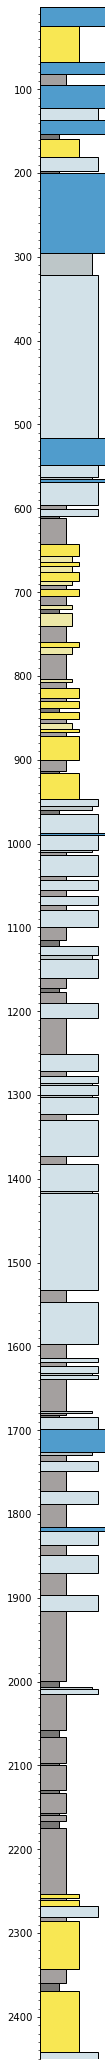

In [32]:
strip.plot(legend=legend, lw=1, aspect=20)

## Write CSV or LAS3

In [11]:
print(strip.to_csv())

Top,Base,Component
7.7596266044340725,32.67211201866978,"Limestone, porous"
32.67211201866978,74.32905484247375,"Sandstone, porous"
74.32905484247375,84.13068844807468,"Limestone, porous"
84.13068844807468,101.28354725787631,"Marl/shale, seal"
101.28354725787631,164.17736289381563,"Limestone, porous"
164.17736289381563,189.08984830805136,"Sandstone, porous"
189.08984830805136,201.34189031505252,"Limestone, compact"
201.34189031505252,300.1750291715286,"Limestone, porous"
300.1750291715286,322.6371061843641,"Dolomite, compact"
322.6371061843641,524.7957992998834,"Limestone, compact"
524.7957992998834,551.3418903150525,"Limestone, porous"
551.3418903150525,615.0525087514585,"Limestone, compact"
615.0525087514585,643.6406067677947,"Marl/shale, seal"
643.6406067677947,659.5682613768962,"Sandstone, porous"
659.5682613768962,682.8471411901984,"Sandstone, compact"
682.8471411901984,742.8821470245041,"Sandstone, porous"
742.8821470245041,818.8448074679113,"Marl/shale, seal"
818.8448074679113,8

In [12]:
print(strip.to_las3())

~Lithology_Parameter
LITH .   Striplog         : Lithology source          {S}
LITHD.   MD               : Lithology depth reference {S}

~Lithology_Definition
LITHT.M                   : Lithology top depth       {F}
LITHB.M                   : Lithology base depth      {F}
LITHD.                    : Lithology description     {S}

~Lithology_Data | Lithology_Definition
7.7596266044340725,32.67211201866978,"Limestone, porous"
32.67211201866978,74.32905484247375,"Sandstone, porous"
74.32905484247375,84.13068844807468,"Limestone, porous"
84.13068844807468,101.28354725787631,"Marl/shale, seal"
101.28354725787631,164.17736289381563,"Limestone, porous"
164.17736289381563,189.08984830805136,"Sandstone, porous"
189.08984830805136,201.34189031505252,"Limestone, compact"
201.34189031505252,300.1750291715286,"Limestone, porous"
300.1750291715286,322.6371061843641,"Dolomite, compact"
322.6371061843641,524.7957992998834,"Limestone, compact"
524.7957992998834,551.3418903150525,"Limestone, porous"


# ASIDE

$$ x + 2y - 8 = 0 $$

or

$$ -\frac{1}{2}x + 4 = y $$

Let's look at this through the lens of linear algebra:

$$ Gm = d $$

and machine learning:

$$ Xm = y $$

In fact, re-reading this myself, I think it would have made more sense to talk about a *model* like:

$$ ax + by = c $$

is equivalent to:

$$ \frac{a}{b}x + \frac{c}{b} = y $$

**Note** that $y$ is different here, it's the 'target', not another variable.

Then we have some data, $\mathbf{X} = [x_1, x_2, x_3]$ and some coefficients $a, b, c$.

In [6]:
X = [
  [0, 1],
  [8, 1],
]

y = [4, 0]

In [10]:
X = [
  [8, 1],
]

y = [0]

In [12]:
import numpy.linalg as la

la.lstsq(X, y)

<ipython-input-12-0d9c18a3ef88>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  la.lstsq(X, y)


(array([-0.,  0.]), array([], dtype=float64), 1, array([8.06225775]))

<hr />

<p style="color:gray">©2021 Agile Geoscience. Licensed CC-BY. <a href="https://github.com/agile-geoscience/striplog">striplog.py</a></p>